# Group Members:
# Tian Wang wttian@bu.edu		Tianhe Wang thwang@bu.edu  

# Qiyue Sun coolsqy@bu.edu	Xinyu Deng xinyu618@bu.edu


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import chi2
import cvxpy as cp
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

### Data Preparation

In [2]:
returns = pd.read_csv('dow_jones_returns.csv')
crypto_returns = pd.read_csv('crypto_coins_returns.csv')

In [3]:
returns.set_index("Date", inplace=True) 
returns.index = pd.to_datetime(returns.index)
crypto_returns.set_index("Date", inplace=True) 
crypto_returns.index = pd.to_datetime(crypto_returns.index)

### Methodology Functions

In [4]:
def calculate_cvar(weights, asset_returns, alpha):
    port_losses = -np.dot(asset_returns, weights)
    var_threshold = np.percentile(port_losses, alpha*100)
    cvar = port_losses[port_losses > var_threshold].mean()
    return cvar

def weight_constraint(weights):
    return np.sum(weights) - 1

def calculate_hhi(weights):
    return np.sum(weights ** 2)

def calculate_turnover(weights_t, weights_t_next):
    return np.sum(np.abs(weights_t_next - weights_t))

def calculate_no_assets(weights, threshold=1e-6):
    return np.sum(weights>threshold)

In [5]:
def rolling_meanvariance(data, start, end, portfolio_number=50, bu=False, eu=False):
    results = []
    quarters = pd.date_range(start=start, end=end, freq="QS")
    previous_weights = None
    for i in range(len(quarters)-5):
        train_start = quarters[i]
        train_end = quarters[i+4]
        test_end = quarters[i+5]
        
        train_data = data[train_start:train_end]
        test_data = data[train_end:test_end]
        
        missing_ratio = data.isna().mean()
        threshold = 0.1
        train_data = train_data.loc[:, missing_ratio < threshold].dropna()
        test_data = test_data.loc[:, missing_ratio < threshold].dropna()
        mean_returns = train_data.mean() 
        cov_matrix = train_data.cov() 
        variances = train_data.var(axis=0).values
        cov_mu = np.diag(variances)
        g = np.sqrt(variances)
        n_assets = len(mean_returns)
        target_returns = np.linspace(mean_returns.min(), mean_returns.max(), portfolio_number)

        portfolios = []

        for target in target_returns:
            x = cp.Variable(n_assets, nonneg=True)
            constraints = [
                cp.sum(x) == 1,
                mean_returns.values @ x - target >= 0,
                x <= 1
            ]
            if bu:
                # mvbu_objective: np.dot(epsilon, weight) + weight.T cov_matrix weight
                epsilon = 1.96 * train_data.std(axis=0).values / np.sqrt(252)
                # cp.quad_form(x, cov_matrix) is x^T Σ x
                objective_expr = epsilon @ x + cp.quad_form(x, cov_matrix)
                objective = cp.Minimize(objective_expr)
            elif eu:
                # mveu_objective: variance + uncertainty_penalty
                # variance = x^T Σ x
                # uncertainty_penalty = epsilon * sqrt(x^T Σ_μ x)
                alpha = 0.95
                chi2_value = chi2.ppf(alpha, df=n_assets)
                epsilon = np.sqrt(chi2_value)
                variance_expr = cp.quad_form(x, cov_matrix)
                uncertainty_penalty_expr = epsilon * cp.norm(cp.multiply(g, x), 2)
                objective = cp.Minimize(variance_expr + uncertainty_penalty_expr)
            else:
                # portfolio_variance: x^T Σ x
                objective_expr = cp.quad_form(x, cov_matrix)
                objective = cp.Minimize(objective_expr)

            prob = cp.Problem(objective, constraints)
            result = prob.solve(solver=cp.GUROBI, verbose=False)

            weights = x.value
            portfolios.append({
                    "Weights": weights,
                    "HHI": calculate_hhi(weights),  
                    "No Assets": calculate_no_assets(weights)
                })
        test_returns = test_data.values
        test_results = []

        for j, portfolio in enumerate(portfolios):
            weights = portfolio['Weights']
            realized_return = np.dot(test_data.values, weights)
            turnover = calculate_turnover(previous_weights[j], weights) if previous_weights is not None else np.nan
            sharpe_ratio = realized_return.mean()/realized_return.std()
            downside_risk = realized_return[realized_return < 0].std()
            sortino_ratio = realized_return.mean() / downside_risk if downside_risk > 0 else np.nan 
            cvar = calculate_cvar(weights, test_returns, alpha=0.95)
            test_results.append({
                "Realized Return": realized_return.mean(),
                "Std":realized_return.std(),
                "NoAssets": portfolio["No Assets"],
                "HHI": portfolio["HHI"],
                "Turnover": turnover,
                "Weights": weights,
                "Sharpe ratio":sharpe_ratio,
                "Sortino ratio":sortino_ratio,
                "CVaR": cvar
            })

        previous_weights = [portfolio["Weights"] for portfolio in portfolios]
        results.append({
            "Train Period": (train_start, train_end - pd.Timedelta(days=1)),
            "Test Period": (train_end, test_end - pd.Timedelta(days=1)),
            "Test Results": test_results
        })
    return results

In [6]:
def rolling_cvar(data, start, end):
    quarters = pd.date_range(start=start, end=end, freq="QS")
    previous_weights = None
    results = []
    for i in range(len(quarters)-5):
        train_start = quarters[i]
        train_end = quarters[i+4]
        test_end = quarters[i+5]

        train_data = data[train_start:train_end]
        test_data = data[train_end:test_end]

        missing_ratio = data.isna().mean()
        threshold = 0.1
        train_data = train_data.loc[:, missing_ratio < threshold].dropna()
        test_data = test_data.loc[:, missing_ratio < threshold].dropna()
        mean_returns = train_data.mean()
        cov_matrix = train_data.cov()
        mu_star_values = np.linspace(mean_returns.min(), mean_returns.max(), 50)
        n_assets = len(mean_returns)
        T = train_data.shape[0]
                
        frontier_solutions = []
        frontier_thetas = []
        
        beta = 0.95 
        mu = mean_returns.values

        for mu_star in mu_star_values:
            x = cp.Variable(n_assets, nonneg=True) 
            y = cp.Variable(T, nonneg=True)  
            alpha = cp.Variable()  
            objective = cp.Minimize(alpha + (1 / ((1 - beta) * T)) * cp.sum(y))
            constraints = [
                alpha + y + train_data.values @ x >= 0,  
                mu @ x >= mu_star,       
                cp.sum(x) == 1,
            ]
            prob = cp.Problem(objective, constraints)
            result = prob.solve(solver=cp.GUROBI, verbose=False)
            x_sol = x.value
            
            if x_sol is not None:
                frontier_solutions.append(x_sol)
                frontier_thetas.append(result)
            else:
                frontier_solutions.append(None)
                frontier_thetas.append(None)
                
        test_results = []
        # Evalueate on the test set
        for i, x_sol in enumerate(frontier_solutions):
            realized_return = test_data.values @ x_sol
            noasset = calculate_no_assets(x_sol)
            hhi = calculate_hhi(x_sol)
            turnover = calculate_turnover(previous_weights[i], x_sol) if previous_weights is not None else np.nan
            cvar = calculate_cvar(x_sol, test_data.values, 0.95)
            sharpe_ratio = realized_return.mean()/realized_return.std()
            downside_risk = realized_return[realized_return < 0].std()
            sortino_ratio = realized_return.mean() / downside_risk if downside_risk > 0 else np.nan 
        
            test_results.append({
                'Realized Return': realized_return.mean(),
                'Std': realized_return.std(),
                'NoAssets': noasset,
                'HHI': hhi,
                'Turnover': turnover,
                'Weights': x_sol,
                'Sharpe ratio':sharpe_ratio,
                'Sortino ratio':sortino_ratio,
                'CVaR': cvar
            })
        previous_weights = [sol for sol in frontier_solutions]
        results.append({
            "Train Period": (train_start, train_end - pd.Timedelta(days=1)),
            "Test Period": (train_end, test_end - pd.Timedelta(days=1)),
            "Test Results": test_results
        })
    return results

In [7]:
def solve_worst_case_cvar(R_list, tau_list, mu_matrix, beta, mu_star):
    M = len(R_list)
    N = R_list[0].shape[1]
    one_minus_beta = 1 - beta

    x = cp.Variable(N, nonneg=True)
    alpha = cp.Variable()
    theta = cp.Variable()
    
    constraints = []
    # build constraints for each distribution
    for k in range(M):
        T_k = R_list[k].shape[0]
        y_k = cp.Variable(T_k, nonneg=True)

        # alpha + (1/(1-beta)) * sum(tau_k * y_k) <= theta
        constraints.append(alpha + (1/one_minus_beta * tau_list[k])* cp.sum(y_k) <= theta)

        # alpha + y_t^k + R_t^k x >= 0
        for t in range(T_k):
            constraints.append(alpha + y_k[t] + R_list[k][t,:] @ x >= 0)

        # mu_k x >= mu_star
        constraints.append(mu_matrix[k,:] @ x >= mu_star)
        
    # sum x = 1
    constraints.append(cp.sum(x) == 1)

    objective = cp.Minimize(theta)
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver=cp.GUROBI, verbose=False)

    return x.value, theta.value, prob.status

def worst_case_cvar(data, start, end):
    quarters = pd.date_range(start=start, end=end, freq="QS")
    previous_weights = None
    results = []
    for i in range(len(quarters)-5):
        print(f'Round {i+1}')
        train_start = quarters[i]
        train_end = quarters[i+4]
        test_end = quarters[i+5]

        train_data = data[train_start:train_end]
        test_data = data[train_end:test_end]

        missing_ratio = data.isna().mean()
        threshold = 0.1
        train_data = train_data.loc[:, missing_ratio < threshold].dropna()
        test_data = test_data.loc[:, missing_ratio < threshold].dropna()
        mean_returns = train_data.mean()
        cov_matrix = train_data.cov()
        mu_star_values = np.linspace(mean_returns.min(), mean_returns.max(), 50)
        n_assets = len(mean_returns)
        T_k = train_data.shape[0]
        R_list = []
        for _ in range(2):
            perturbation = np.random.randn(n_assets) * 0.0001
            R_scenarios = np.random.multivariate_normal(mean_returns + perturbation, cov_matrix, size=T_k)
            R_list.append(R_scenarios)
        tau_list = np.ones(n_assets)/n_assets
        mu_matrix = np.mean(R_list, axis=0)
        
        frontier_solutions = []

        for mu_star in mu_star_values:
            x_sol, theta_sol, status = solve_worst_case_cvar(R_list, tau_list, mu_matrix, 0.95, mu_star)
            if x_sol is not None:
                frontier_solutions.append(x_sol)
            else:
                frontier_solutions.append(np.nan)

        # evaluate the performance on each test period
        test_results = []

        for i, x_sol in enumerate(frontier_solutions):
            if x_sol is not np.nan:
                realized_return = test_data.values @ x_sol
                mean = realized_return.mean()
                std = realized_return.std()
                noasset = calculate_no_assets(x_sol)
                hhi = calculate_hhi(x_sol)
                turnover = calculate_turnover(previous_weights[i], x_sol) if previous_weights is not None else np.nan
                cvar = calculate_cvar(x_sol, test_data.values, 0.95)
                sharpe_ratio = realized_return.mean()/realized_return.std()
                downside_risk = realized_return[realized_return < 0].std()
                sortino_ratio = realized_return.mean() / downside_risk if downside_risk > 0 else np.nan 
            else:
                mean = np.nan
                std = np.nan
                sharpe_ratio = np.nan
                sortino_ratio = np.nan
                noasset = np.nan
                hhi = np.nan
                cvar = np.nan
                turnover = np.nan
                
            test_results.append({
                'Realized Return': mean,
                'Std': std,
                'NoAssets': noasset,
                'HHI': hhi,
                'Turnover': turnover,
                'Weights': x_sol,
                'Sharpe ratio':sharpe_ratio,
                'Sortino ratio':sortino_ratio,
                'CVaR': cvar
            })

        previous_weights = [sol for sol in frontier_solutions]
        results.append({
            "Train Period": (train_start, train_end - pd.Timedelta(days=1)),
            "Test Period": (train_end, test_end - pd.Timedelta(days=1)),
            "Test Results": test_results
        })
        
    return results

In [8]:
def rolling_omega(data, start, end):
    delta_values = np.linspace(0,1,11)
    returns = []
    stds = []
    portfolios = []
    sharpes = []
    hhis = []
    turnovers = []
    noassets = []
    sortinos = []
    cvar = []
    quarters = pd.date_range(start=start, end=end, freq="QS")
    previous_weights = None
    for i in range(len(quarters)-5):
        train_start = quarters[i]
        train_end = quarters[i+4]
        test_end = quarters[i+5]
        
        train_data = data[train_start:train_end]
        test_data = data[train_end:test_end]
        
        missing_ratio = data.isna().mean()
        threshold = 0.1
        train_data = train_data.loc[:, missing_ratio < threshold].dropna()
        test_data = test_data.loc[:, missing_ratio < threshold].dropna()
         
        T, n_assets = train_data.shape
        x = cp.Variable(n_assets, nonneg=True, value=np.ones(n_assets) / n_assets)
        mu = train_data.mean(axis=0).values
        best_weights = None
        best_result = -np.inf
        for delta in delta_values:
            tau = 0  # Set tau to 0 as described in the image
            max_weight = 0.2
            downside_risk = cp.sum(cp.maximum(0, tau - train_data.values @ x)) / T
            objective = cp.Maximize(delta * (mu @ x - tau) - (1 - delta) * downside_risk)
            constraints = [cp.sum(x) == 1, x <= max_weight]
            prob = cp.Problem(objective, constraints)
            result = prob.solve(solver=cp.GUROBI, verbose=False)
            # downside_risk = np.mean([max(0, tau - np.dot(train_data.values[i], x.value)) for i in range(T)])
            # print(downside_risk)
            if result > best_result:
                best_result = result
                best_weights = x.value
                
        turnover = calculate_turnover(previous_weights, best_weights) if previous_weights is not None else np.nan      
        portfolios.append(best_weights)
        portfolio_returns = np.dot(test_data.values, best_weights)
        # Assume rf=0
        sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std()
        downside_risk = portfolio_returns[portfolio_returns < 0].std()
        sortino_ratio = portfolio_returns.mean() / downside_risk if downside_risk > 0 else np.nan
        turnovers.append(turnover)
        noassets.append(calculate_no_assets(best_weights))
        hhis.append(calculate_hhi(best_weights))
        sharpes.append(sharpe_ratio)
        sortinos.append(sortino_ratio)
        returns.append(portfolio_returns.mean())
        stds.append(portfolio_returns.std())
        cvar.append(calculate_cvar(best_weights, test_data.values, alpha=0.95))
        previous_weights = x.value
    
    return returns, [np.mean(returns), np.mean(stds), np.mean(noassets), np.mean(hhis), np.nanmean(turnovers), np.mean(sharpes), np.mean(sortinos), np.mean(cvar)]

In [9]:
def worst_omega_rolling(data, start, end):
    returns = []
    stds = []
    portfolios = []
    sharpes = []
    hhis = []
    turnovers = []
    noassets = []
    sortinos = []
    cvar = []
    quarters = pd.date_range(start=start, end=end, freq="QS")
    
    previous_weights = None
    for i in range(len(quarters) - 5):
        train_start = quarters[i]
        train_end = quarters[i + 4]
        test_end = quarters[i + 5]

        train_data = data[train_start:train_end]
        test_data = data[train_end:test_end]

        missing_ratio = data.isna().mean()
        threshold = 0.1
        train_data = train_data.loc[:, missing_ratio < threshold].dropna()
        test_data = test_data.loc[:, missing_ratio < threshold].dropna()

        mean_returns = train_data.mean()
        cov_matrix = train_data.cov()

        N = train_data.shape[1]
        M = 2
        T_k = train_data.shape[0]
        R_list = []
        for _ in range(M):
            perturbation = np.random.randn(N) * 0.0001
            R_scenarios = np.random.multivariate_normal(mean_returns + perturbation, cov_matrix, size=T_k)
            R_list.append(R_scenarios)

        theta_var = cp.Variable()  
        x = cp.Variable(N, nonneg=True)  
        delta_values = np.linspace(0, 1, 11)  
        
        best_theta = -np.inf
        best_weights = None
        max_weights = 0.2
        for delta in delta_values:
            
            constraints = [cp.sum(x) == 1, x <= max_weights]
            for k in range(M):
                initial_x = np.ones(N) / N
                R_k = R_list[k]
                T_k_val = R_k.shape[0]
                downside_risk = np.mean(np.maximum(0, -R_k @ initial_x))
                
                mu_k = np.mean(R_k, axis=0)
                y_k = cp.Variable(T_k_val, nonneg=True)  
                # y_k[t] >= 0 和 y_k[t] >= -R_t^k x
                constraints += [
                    y_k >= -R_k @ x
                ]

                # delta * (mu_k x) - (1-delta) * mean(y_k) - theta >= 0
                constraints.append(delta * (mu_k @ x) - (1 - delta) * cp.sum(y_k) / T_k_val - theta_var >= 0)

            objective = cp.Maximize(theta_var)
            prob = cp.Problem(objective, constraints)

            try:
                result = prob.solve(solver=cp.GUROBI, verbose=False)
                if prob.status in ["optimal", "optimal_inaccurate"] and theta_var.value > best_theta:
                    best_theta = theta_var.value
                    best_weights = x.value
            except Exception as e:
                print(f"Optimization failed for delta={delta}: {e}")

        portfolios.append(best_weights)
        portfolio_returns = np.dot(test_data.values, best_weights)
        sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std()
        downside_risk = portfolio_returns[portfolio_returns < 0].std()
        sortino_ratio = portfolio_returns.mean() / downside_risk if downside_risk > 0 else np.nan
        turnover = calculate_turnover(previous_weights, best_weights) if previous_weights is not None else np.nan
        no_assets = calculate_no_assets(best_weights)
        hhi = calculate_hhi(best_weights)
        cvar_value = calculate_cvar(best_weights, test_data.values, alpha=0.95)
        
        turnovers.append(turnover)
        noassets.append(no_assets)
        hhis.append(hhi)
        sharpes.append(sharpe_ratio)
        sortinos.append(sortino_ratio)
        returns.append(portfolio_returns.mean())
        stds.append(portfolio_returns.std())
        cvar.append(cvar_value)
        previous_weights = best_weights

    return returns, [np.mean(returns), np.mean(stds), np.mean(noassets), np.mean(hhis), 
                     np.nanmean(turnovers), np.mean(sharpes), np.mean(sortinos), np.mean(cvar)]


In [10]:
def calculate_average_performance(results, length):
    mean_returns = []
    mean_stds = []
    mean_noassets = []
    mean_hhis = []
    mean_turnovers = []
    mean_sharpes = []
    mean_sortinos = []
    mean_cvars = []

    for i in range(length):
        for j in range(50):
            mean_returns.append(results[i]['Test Results'][j]['Realized Return'])
            mean_stds.append(results[i]['Test Results'][j]['Std'])
            mean_noassets.append(results[i]['Test Results'][j]['NoAssets'])
            mean_hhis.append(results[i]['Test Results'][j]['HHI'])
            mean_turnovers.append(results[i]['Test Results'][j]['Turnover'])
            mean_sharpes.append(results[i]['Test Results'][j]['Sharpe ratio'])
            mean_sortinos.append(results[i]['Test Results'][j]['Sortino ratio'])
            mean_cvars.append(results[i]['Test Results'][j]['CVaR'])

    print('Mean: ',np.nanmean(mean_returns))
    print('Std: ', np.nanmean(mean_stds))
    print('Number of Assets: ', np.nanmean(mean_noassets))
    print('HHI: ', np.nanmean(mean_hhis))
    print('Turnover: ', np.nanmean(mean_turnovers))
    print('Sharpe ratio: ', np.nanmean(mean_sharpes))
    print('Sortino ratio: ', np.nanmean(mean_sortinos))
    print('CVaR: ', np.nanmean(mean_cvars))

In [11]:
def get_tables(results, index, length):
    table_sc = pd.DataFrame()
    table_ret = pd.DataFrame()
    table_std = pd.DataFrame()
    table_cvar = pd.DataFrame()
    returns_ = []
    for ii, result in enumerate(results):
        max_sc = -np.inf
        max_return = -np.inf
        min_std = np.inf
        min_cvar = np.inf
        for i in range(50):
            sc = result['Test Results'][i]["Sharpe ratio"]
            ret = result['Test Results'][i]["Realized Return"]
            std = result['Test Results'][i]["Std"]
            cvar = result['Test Results'][i]["CVaR"]

            if sc > max_sc:
                max_sc = sc
                max_index_sc = i
            if ret > max_return:
                max_return = ret
                max_index_ret = i
            if std < min_std:
                min_std = std
                min_index_std = i
            if cvar < min_cvar:
                min_cvar = cvar
                min_index_cvar = i

        result_sc = result['Test Results'][max_index_sc].copy()
        del result_sc['Weights']
        result_ret = result['Test Results'][max_index_ret].copy()
        del result_ret['Weights']
        result_std = result['Test Results'][min_index_std].copy()
        del result_std['Weights']
        result_cvar = result['Test Results'][min_index_cvar].copy()
        del result_cvar['Weights']
        t_sc = pd.DataFrame(result_sc, index=[index])
        t_ret = pd.DataFrame(result_ret, index=[index])
        t_std = pd.DataFrame(result_std, index=[index])
        t_cvar = pd.DataFrame(result_cvar, index=[index])
        table_sc = table_sc.fillna(0) + t_sc
        table_sc = table_sc[t_sc.columns]
        table_ret = table_ret.fillna(0) + t_ret
        table_ret = table_ret[t_ret.columns]
        table_std = table_std.fillna(0) + t_std
        table_std = table_std[t_std.columns]
        table_cvar = table_cvar.fillna(0) + t_cvar
        table_std = table_cvar[t_cvar.columns]

        return_ = result_sc["Realized Return"]
        returns_.append(return_)
    table_sc = table_sc/length
    table_ret = table_ret/length
    table_std = table_std/length
    table_cvar = table_cvar/length

    return table_sc, table_ret, table_std, table_cvar, returns_

### Mean-Variance (Nominal MV, MVBU, MVEU)

In [12]:
mv_results = rolling_meanvariance(returns, "2005-01-01", "2020-07-01")
mvbu_results = rolling_meanvariance(returns, "2005-01-01", "2020-07-01", bu=True)
mveu_results = rolling_meanvariance(returns, "2005-01-01", "2020-07-01", eu=True)

Restricted license - for non-production use only - expires 2026-11-23


In [13]:
c_mv_results = rolling_meanvariance(crypto_returns, "2020-07-01", "2024-07-01")
c_mvbu_results = rolling_meanvariance(crypto_returns, "2020-07-01", "2024-07-01", bu=True)
c_mveu_results = rolling_meanvariance(crypto_returns, "2020-07-01", "2024-07-01", eu=True)

In [14]:
print('MV results:')
calculate_average_performance(mv_results, 58)
print('-----------------------------------------')
print('MVBU results:')
calculate_average_performance(mvbu_results, 58)
print('-----------------------------------------')
print('MVEU results:')
calculate_average_performance(mveu_results, 58)
print('-----------------------------------------')
print('Crypto MV results:')
calculate_average_performance(c_mv_results, 12)
print('-----------------------------------------')
print('Crypto MVBU results:')
calculate_average_performance(c_mvbu_results, 12)
print('-----------------------------------------')
print('Crypto MVEU results:')
calculate_average_performance(c_mveu_results, 12)

MV results:
Mean:  0.0004640664135787499
Std:  0.009739534195699003
Number of Assets:  11.291724137931034
HHI:  0.2564252780358683
Turnover:  0.7327237041752634
Sharpe ratio:  0.08189230442852917
Sortino ratio:  0.14811779613726986
CVaR:  0.019925146777277993
-----------------------------------------
MVBU results:
Mean:  0.0004560031708918668
Std:  0.010870068775744814
Number of Assets:  2.7189655172413794
HHI:  0.7056284662478725
Turnover:  0.9200035696726113
Sharpe ratio:  0.06317352899060448
Sortino ratio:  0.11905217764876092
CVaR:  0.0223704223032006
-----------------------------------------
MVEU results:
Mean:  0.0005233958772274409
Std:  0.010523121892331932
Number of Assets:  21.60965517241379
HHI:  0.1340031161268965
Turnover:  0.480477945886287
Sharpe ratio:  0.089060019708841
Sortino ratio:  0.15262432505243662
CVaR:  0.02172325516669268
-----------------------------------------
Crypto MV results:
Mean:  0.007505910629314789
Std:  0.09962340163316961
Number of Assets:  4.256

### CVAR

In [15]:
cvar_results = rolling_cvar(returns, "2005-01-01", "2020-07-01")
c_cvar_results = rolling_cvar(crypto_returns, "2020-07-01", "2024-07-01")

In [16]:
calculate_average_performance(cvar_results, 58)
print('-------------------------')
calculate_average_performance(c_cvar_results, 12)

Mean:  0.0005021171329359578
Std:  0.01004383020665607
Number of Assets:  6.900344827586207
HHI:  0.3018763022922886
Turnover:  0.963412615155095
Sharpe ratio:  0.0790815142796703
Sortino ratio:  0.1405486840190907
CVaR:  0.02046904775609365
-------------------------
Mean:  0.007132087887365754
Std:  0.09875764159507204
Number of Assets:  3.533333333333333
HHI:  0.5174902961326222
Turnover:  0.5640928832660153
Sharpe ratio:  0.04816210492276022
Sortino ratio:  0.13703250904166325
CVaR:  0.13412343366137405


### WCVAR (We don't set the seed so each time the results would be different)

In [17]:
wcvar_results = worst_case_cvar(returns, "2005-01-01", "2020-07-01")

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Round 11
Round 12
Round 13
Round 14
Round 15
Round 16
Round 17
Round 18
Round 19
Round 20
Round 21
Round 22
Round 23
Round 24
Round 25
Round 26
Round 27
Round 28
Round 29
Round 30
Round 31
Round 32
Round 33
Round 34
Round 35
Round 36
Round 37
Round 38
Round 39
Round 40
Round 41
Round 42
Round 43
Round 44
Round 45
Round 46
Round 47
Round 48
Round 49
Round 50
Round 51
Round 52
Round 53
Round 54
Round 55
Round 56
Round 57
Round 58


In [18]:
c_wcvar_results = worst_case_cvar(crypto_returns, "2020-07-01", "2024-07-01")

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Round 11
Round 12


In [19]:
calculate_average_performance(wcvar_results, 58)
print('-------------------------')
calculate_average_performance(c_wcvar_results, 12)

Mean:  0.00045633331621593507
Std:  0.009198962537184049
Number of Assets:  8.23623693379791
HHI:  0.23490194500502307
Turnover:  1.4588916436913015
Sharpe ratio:  0.07957294642505612
Sortino ratio:  0.14493095926629743
CVaR:  0.01866993107082317
-------------------------
Mean:  0.0018341853852645626
Std:  0.035191343892129884
Number of Assets:  5.575238095238095
HHI:  0.3753836613883987
Turnover:  1.2702753425539968
Sharpe ratio:  0.0640808525116941
Sortino ratio:  0.11721381327543795
CVaR:  0.07378510959423107


### Omega Ratio

In [20]:
returns1, omega_results = rolling_omega(returns, "2005-01-01", "2020-07-01")
print(omega_results)
c_returns1, c_omega_results = rolling_omega(crypto_returns, "2020-07-01", "2024-07-01")
print(c_omega_results)

[0.0005300815366875917, 0.012396730769156998, 5.0, 0.2, 0.8280701754385965, 0.07209561058219448, 0.12403889745198066, 0.02560148128835301]
[0.0050858800491878865, 0.06849269697826224, 5.0, 0.20000000000000007, 0.5818181818181819, 0.05153903418113765, 0.1895543523388801, 0.10380312651666668]


### WCOR (Similarly, we don't set the seed so each time the results would be different)

In [21]:
returns2, womega_results = worst_omega_rolling(returns, "2005-01-01", "2020-07-01")
print(womega_results)
c_returns2, c_womega_results = worst_omega_rolling(crypto_returns, "2020-07-01", "2024-07-01")
print(c_womega_results)

[0.0005474291520129761, 0.011864612367000394, 5.568965517241379, 0.19230252199010314, 1.3239536506561054, 0.07858749029488231, 0.1340346049777618, 0.024464858638890984]
[0.004630796781351791, 0.06505816532656107, 5.333333333333333, 0.1962651917695903, 0.9276680895018363, 0.05686907672741031, 0.20275226218684816, 0.10242844500232134]


### Visualization

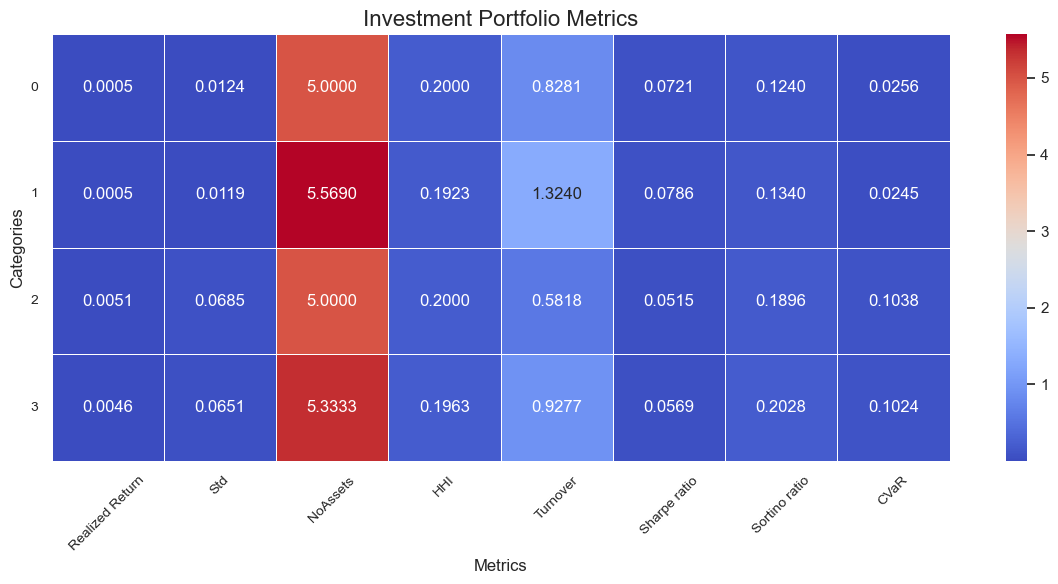

In [22]:
sns.set_theme(style="whitegrid")
columns = ["Realized Return", "Std", "NoAssets", "HHI", "Turnover", "Sharpe ratio", "Sortino ratio", "CVaR"]
data = [
    omega_results, womega_results, c_omega_results, c_womega_results
]

df = pd.DataFrame(data, columns=columns, index=)
df_rounded = df.round(4)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(df_rounded, annot=True, fmt=".4f", cmap="coolwarm", cbar=True, linewidths=0.5)

plt.title("Investment Portfolio Metrics", fontsize=16)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Categories", fontsize=12)

plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)

plt.tight_layout()
plt.show()

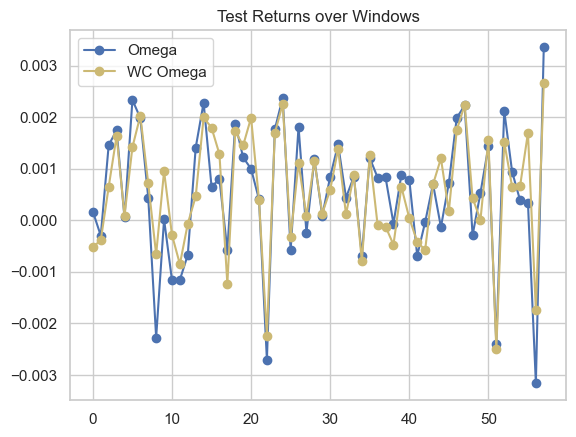

In [23]:
plt.plot(returns1, marker='o', linestyle='-', color='b', label='Omega')
plt.plot(returns2, marker='o', linestyle='-', color='y', label='WC Omega')
plt.title('Test Returns over Windows')
plt.legend()

In [24]:
table_MV_sc, table_MV_ret, table_MV_std, table_MV_cvar, returns_MV = get_tables(mv_results, 'MV', 58)
table_MVBU_sc, table_MVBU_ret, table_MVBU_std, table_MVBU_cvar, returns_MVBU = get_tables(mvbu_results, 'MVBU', 58)
table_MVEU_sc, table_MVEU_ret, table_MVEU_std, table_MVEU_cvar, returns_MVEU = get_tables(mveu_results, 'MVEU', 58)
table_CVAR_sc, table_CVAR_ret, table_CVAR_std, table_CVAR_cvar, returns_CVAR = get_tables(cvar_results, 'CVAR', 58)
table_WCVAR_sc, table_WCVAR_ret, table_WCVAR_std, table_WCVAR_cvar, returns_WCVAR = get_tables(wcvar_results, 'WCVAR', 58)

In [25]:
table_cMV_sc, table_cMV_ret, table_cMV_std, table_cMV_cvar, returns_cMV = get_tables(c_mv_results, 'c_MV', 12)
table_cMVBU_sc, table_cMVBU_ret, table_cMVBU_std, table_cMVBU_cvar, returns_cMVBU = get_tables(c_mvbu_results, 'c_MVBU', 12)
table_cMVEU_sc, table_cMVEU_ret, table_cMVEU_std, table_cMVEU_cvar, returns_cMVEU = get_tables(c_mveu_results, 'c_MVEU', 12)
table_cCVAR_sc, table_cCVAR_ret, table_cCVAR_std, table_cCVAR_cvar, returns_cCVAR = get_tables(c_cvar_results, 'c_CVAR', 12)
table_cWCVAR_sc, table_cWCVAR_ret, table_cWCVAR_std, table_cWCVAR_cvar, returns_cWCVAR = get_tables(c_wcvar_results, 'c_WCVAR', 12)

In [26]:
table_sc = pd.concat([table_MV_sc, table_MVBU_sc, table_MVEU_sc, table_CVAR_sc, table_WCVAR_sc], axis=0)
table_sc.to_csv("MF740_table_sc.csv", index=False)
table_ret = pd.concat([table_MV_ret, table_MVBU_ret, table_MVEU_ret, table_CVAR_ret, table_WCVAR_sc], axis=0)
table_ret.to_csv("MF740_table_ret.csv", index=False)
table_std = pd.concat([table_MV_std, table_MVBU_std, table_MVEU_std, table_CVAR_std, table_WCVAR_sc], axis=0)
table_std.to_csv("MF740_table_std.csv", index=False)
table_cvar = pd.concat([table_MV_cvar, table_MVBU_cvar, table_MVEU_cvar, table_CVAR_cvar, table_WCVAR_cvar], axis=0)
table_std.to_csv("MF740_table_cvar.csv", index=False)

c_table_sc = pd.concat([table_cMV_sc, table_cMVBU_sc, table_cMVEU_sc, table_cCVAR_sc, table_cWCVAR_sc], axis=0)
c_table_sc.to_csv("MF740_c_table_sc.csv", index=False)
c_table_ret = pd.concat([table_cMV_ret, table_cMVBU_ret, table_cMVEU_ret, table_cCVAR_ret, table_cWCVAR_sc], axis=0)
c_table_ret.to_csv("MF740_c_table_ret.csv", index=False)
c_table_std = pd.concat([table_cMV_std, table_cMVBU_std, table_cMVEU_std, table_cCVAR_std, table_cWCVAR_sc], axis=0)
c_table_std.to_csv("MF740_c_table_std.csv", index=False)
c_table_cvar = pd.concat([table_cMV_cvar, table_cMVBU_cvar, table_cMVEU_cvar, table_cCVAR_cvar, table_cWCVAR_cvar], axis=0)
c_table_std.to_csv("MF740_c_table_cvar.csv", index=False)

we take two of them to see the results as examples

In [27]:
table_sc

Realized Return       Std   NoAssets       HHI  Turnover  Sharpe ratio  \
MV            0.001263  0.011278   8.568966  0.412260  0.893575      0.140788   
MVBU          0.001459  0.012310   2.120690  0.767796  1.092084      0.138067   
MVEU          0.001201  0.011924  16.568966  0.310053  0.684419      0.134873   
CVAR          0.001308  0.011324   5.120690  0.439045  0.968630      0.141519   
WCVAR         0.000615  0.008991   8.189655  0.231350  0.983735      0.098788   

       Sortino ratio      CVaR  
MV          0.257127  0.022219  
MVBU        0.256147  0.023538  
MVEU        0.230588  0.023786  
CVAR        0.251486  0.022153  
WCVAR       0.177246  0.018080

In [28]:
c_table_sc

Realized Return       Std  NoAssets       HHI  Turnover  \
c_MV            0.006598  0.101042  3.750000  0.525578  0.460393   
c_MVBU          0.006534  0.099473  2.000000  0.680363  0.625083   
c_MVEU          0.006617  0.107201  5.750000  0.494465  0.439012   
c_CVAR          0.006429  0.106624  2.416667  0.686114  0.144153   
c_WCVAR         0.001334  0.010057  1.833333  0.140472  0.300073   

         Sharpe ratio  Sortino ratio      CVaR  
c_MV         0.093646       0.184016  0.149568  
c_MVBU       0.093102       0.184641  0.149004  
c_MVEU       0.085457       0.165471  0.158515  
c_CVAR       0.086509       0.164902  0.154367  
c_WCVAR      0.047727       0.089730  0.017073

In [29]:
# Replication
data = [
    omega_results, womega_results
]
df = pd.DataFrame(data, columns=columns, index=["OR", "WCOR"])
pd.concat([table_MV_std, table_CVAR_cvar, df], axis=0)

Realized Return       Std   NoAssets       HHI  Turnover  Sharpe ratio  \
MV           0.000446  0.007723  13.396552  0.190700  0.584244      0.092203   
CVAR         0.000512  0.008142   7.948276  0.223879  0.907099      0.092812   
OR           0.000530  0.012397   5.000000  0.200000  0.828070      0.072096   
WCOR         0.000547  0.011865   5.568966  0.192303  1.323954      0.078587   

      Sortino ratio      CVaR  
MV         0.179505  0.015536  
CVAR       0.172142  0.016076  
OR         0.124039  0.025601  
WCOR       0.134035  0.024465

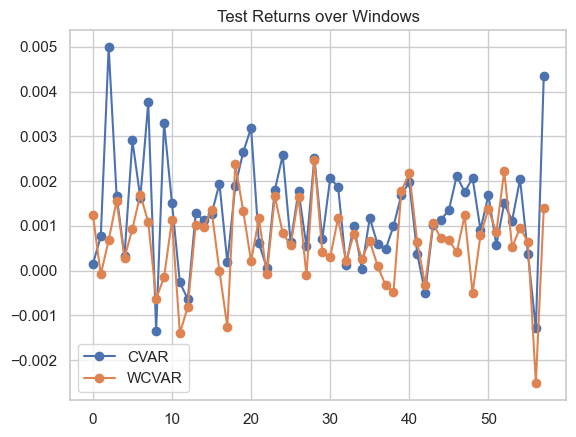

In [30]:
returns_CVAR = np.array(returns_CVAR)
returns_WCVAR = np.array(returns_WCVAR)
plt.plot(returns_CVAR, label="CVAR", marker='o', linestyle='-')
plt.plot(returns_WCVAR, label="WCVAR", marker='o', linestyle='-')
plt.title('Test Returns over Windows')
plt.legend()
plt.show()

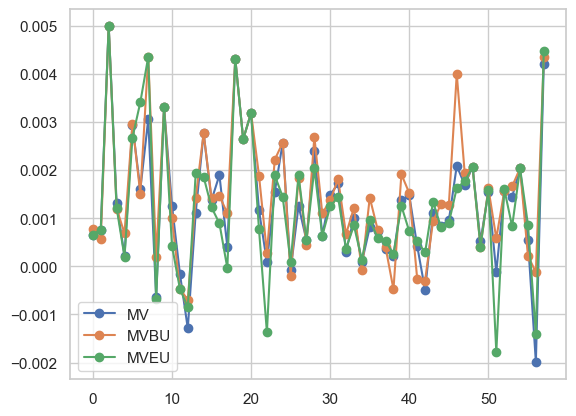

In [31]:
returns_MV = np.array(returns_MV)
returns_MVBU = np.array(returns_MVBU)
returns_MVEU = np.array(returns_MVEU)
plt.plot(returns_MV, label="MV", marker='o', linestyle='-')
plt.plot(returns_MVBU, label="MVBU", marker='o', linestyle='-')
plt.plot(returns_MVEU, label="MVEU", marker='o', linestyle='-')
plt.legend()
plt.show()

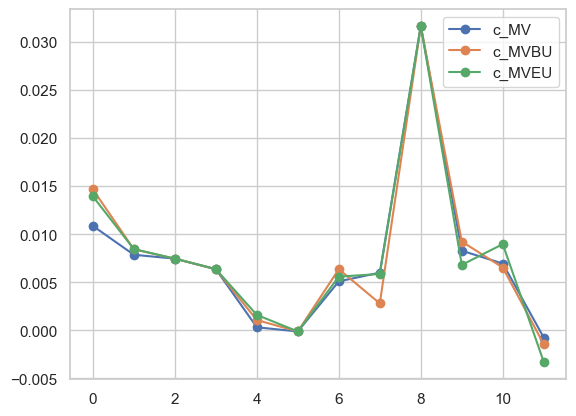

In [32]:
returns_cMV = np.array(returns_cMV)
returns_cMVBU = np.array(returns_cMVBU)
returns_cMVEU = np.array(returns_cMVEU)
plt.plot(returns_cMV, label="c_MV", marker='o', linestyle='-')
plt.plot(returns_cMVBU, label="c_MVBU", marker='o', linestyle='-')
plt.plot(returns_cMVEU, label="c_MVEU", marker='o', linestyle='-')
plt.legend()
plt.show()

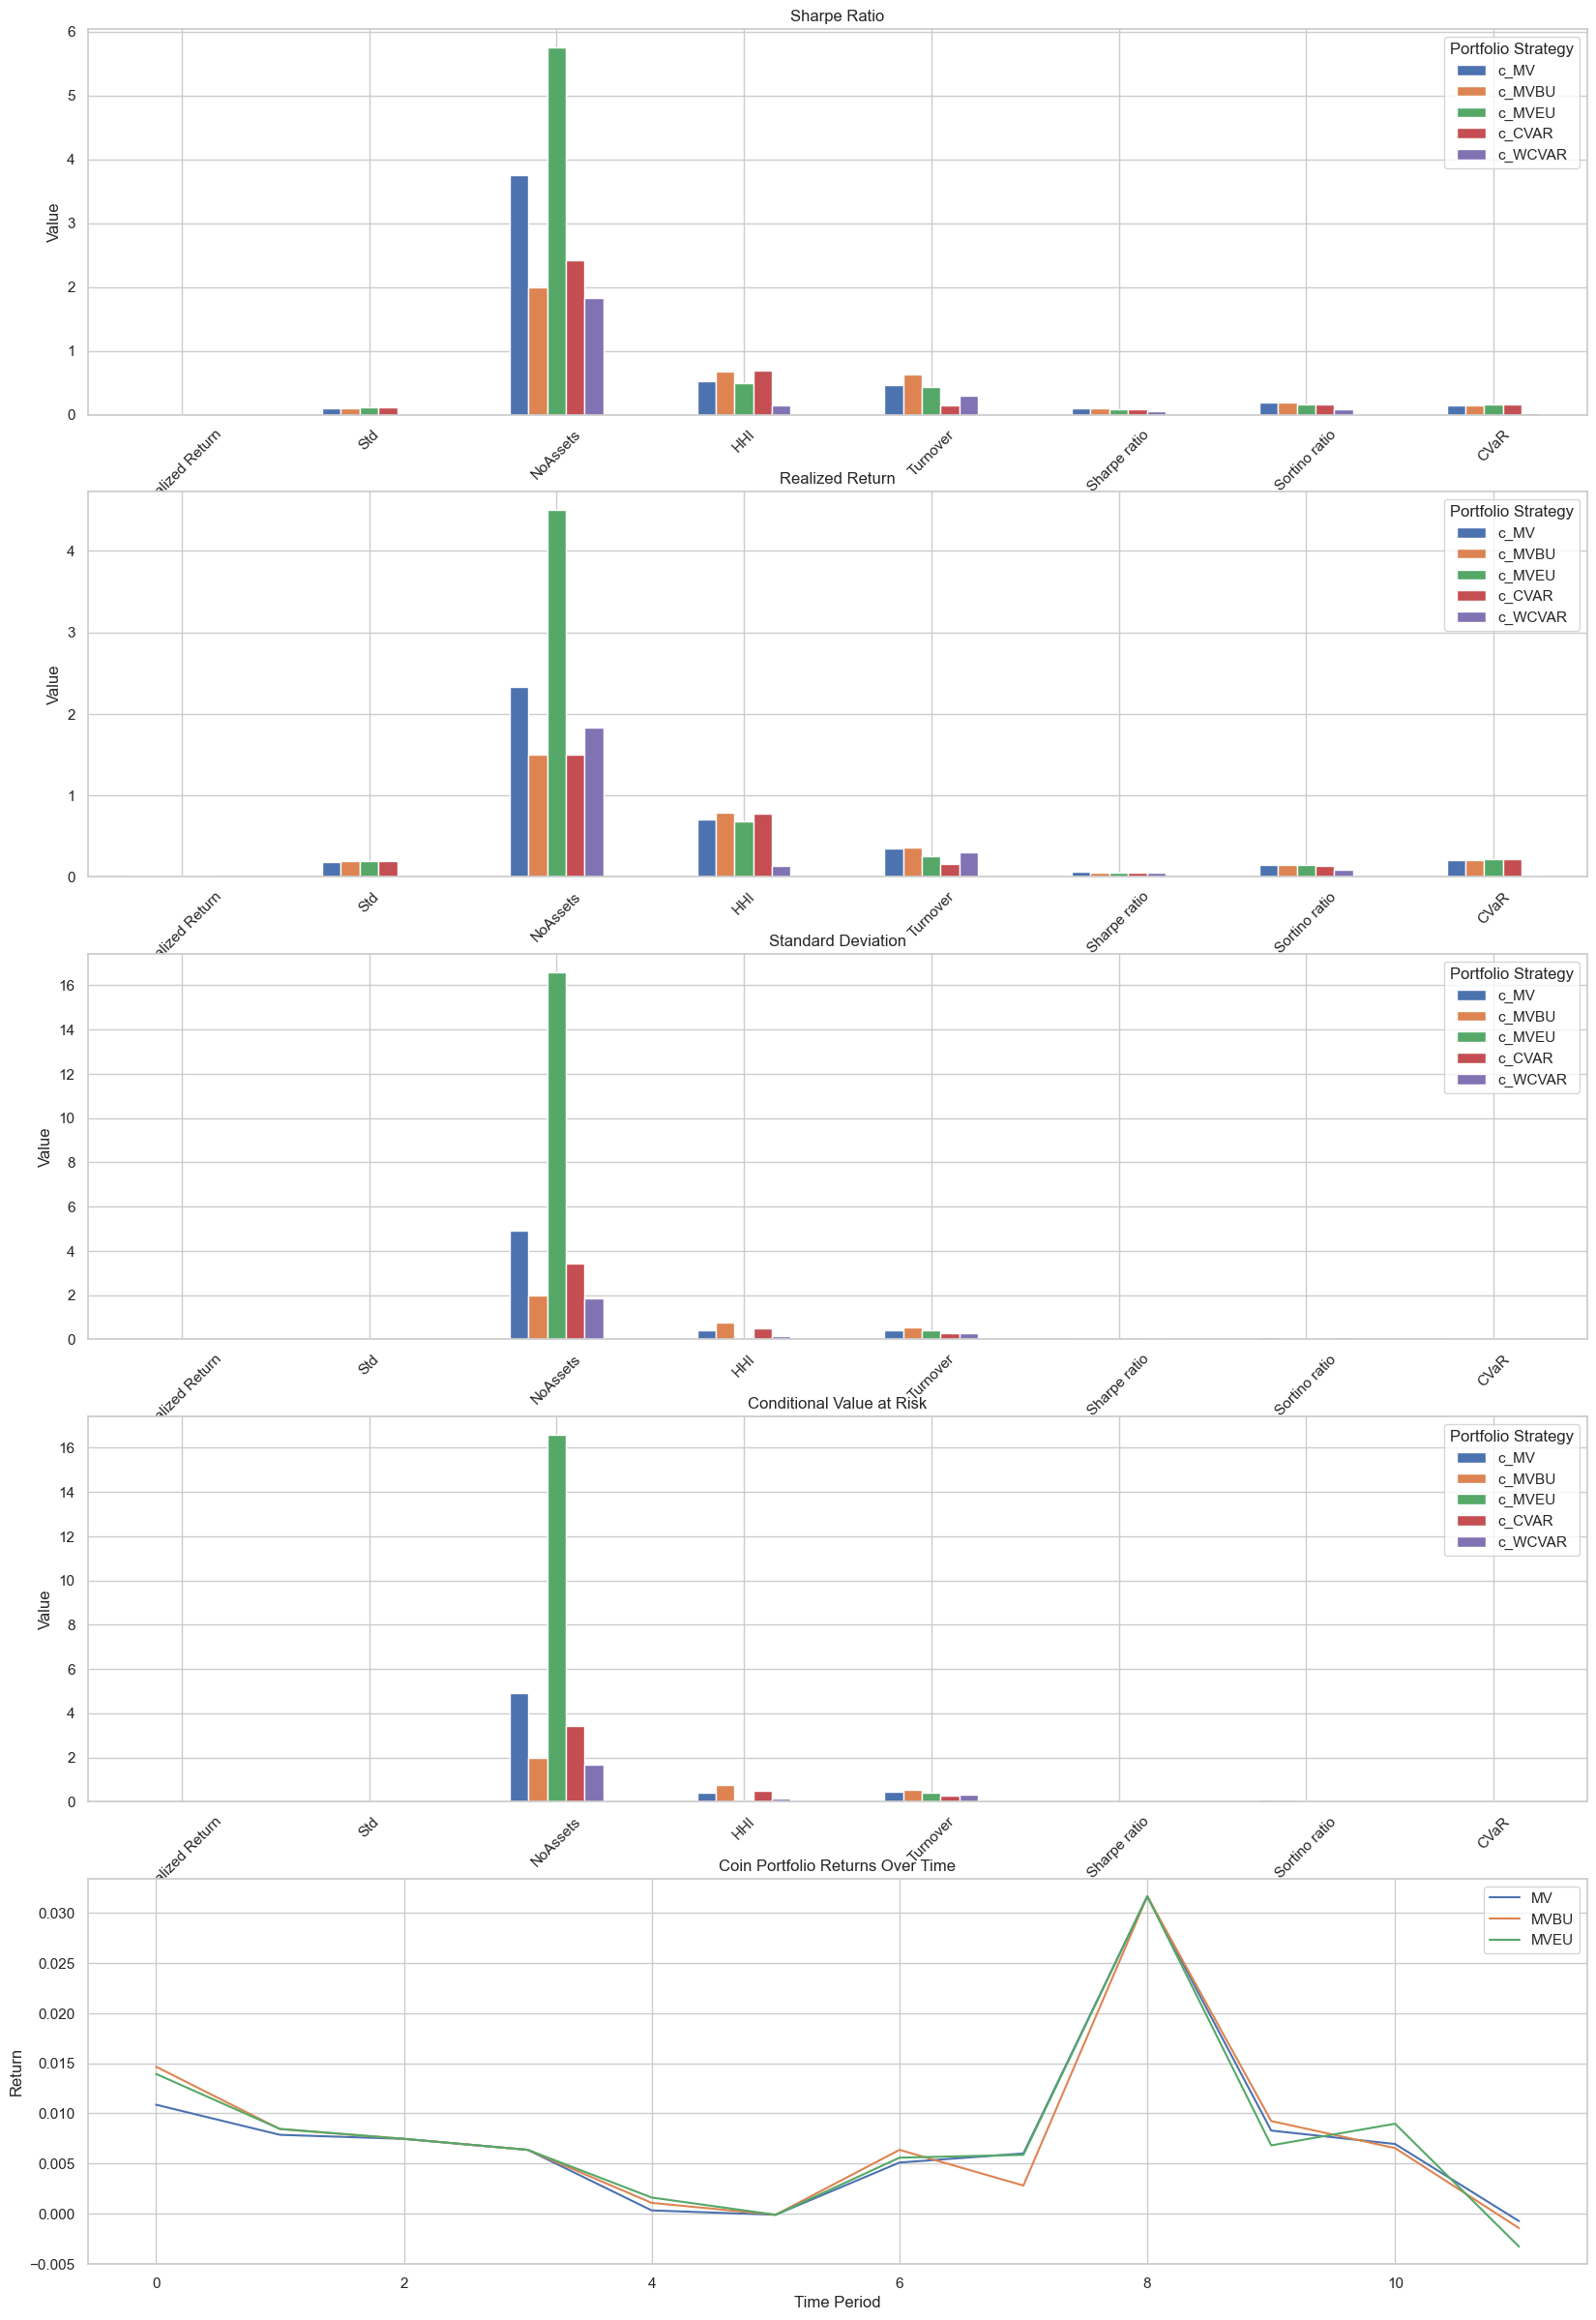

In [33]:
fig, axes = plt.subplots(5, 1, figsize=(20, 30))

# Plot 1: Sharpe Ratio
c_table_sc.T.plot(kind="bar", ax=axes[0], title="Sharpe Ratio")
axes[0].set_xlabel("Metric")
axes[0].set_ylabel("Value")
axes[0].legend(title="Portfolio Strategy")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Realized Return
c_table_ret.T.plot(kind="bar", ax=axes[1], title="Realized Return")
axes[1].set_xlabel("Metric")
axes[1].set_ylabel("Value")
axes[1].legend(title="Portfolio Strategy")
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Standard Deviation
c_table_std.T.plot(kind="bar", ax=axes[2], title="Standard Deviation")
axes[2].set_xlabel("Metric")
axes[2].set_ylabel("Value")
axes[2].legend(title="Portfolio Strategy")
axes[2].tick_params(axis='x', rotation=45)

# Plot 4: CVaR
c_table_cvar.T.plot(kind="bar", ax=axes[3], title="Conditional Value at Risk")
axes[3].set_xlabel("Metric")
axes[3].set_ylabel("Value")
axes[3].legend(title="Portfolio Strategy")
axes[3].tick_params(axis='x', rotation=45)

# Plot 5:  Returns Over Time (Line Plot)
axes[4].plot(returns_cMV, label="MV")
axes[4].plot(returns_cMVBU, label="MVBU")
axes[4].plot(returns_cMVEU, label="MVEU")
axes[4].set_title("Coin Portfolio Returns Over Time")
axes[4].set_xlabel("Time Period")
axes[4].set_ylabel("Return")
axes[4].legend()

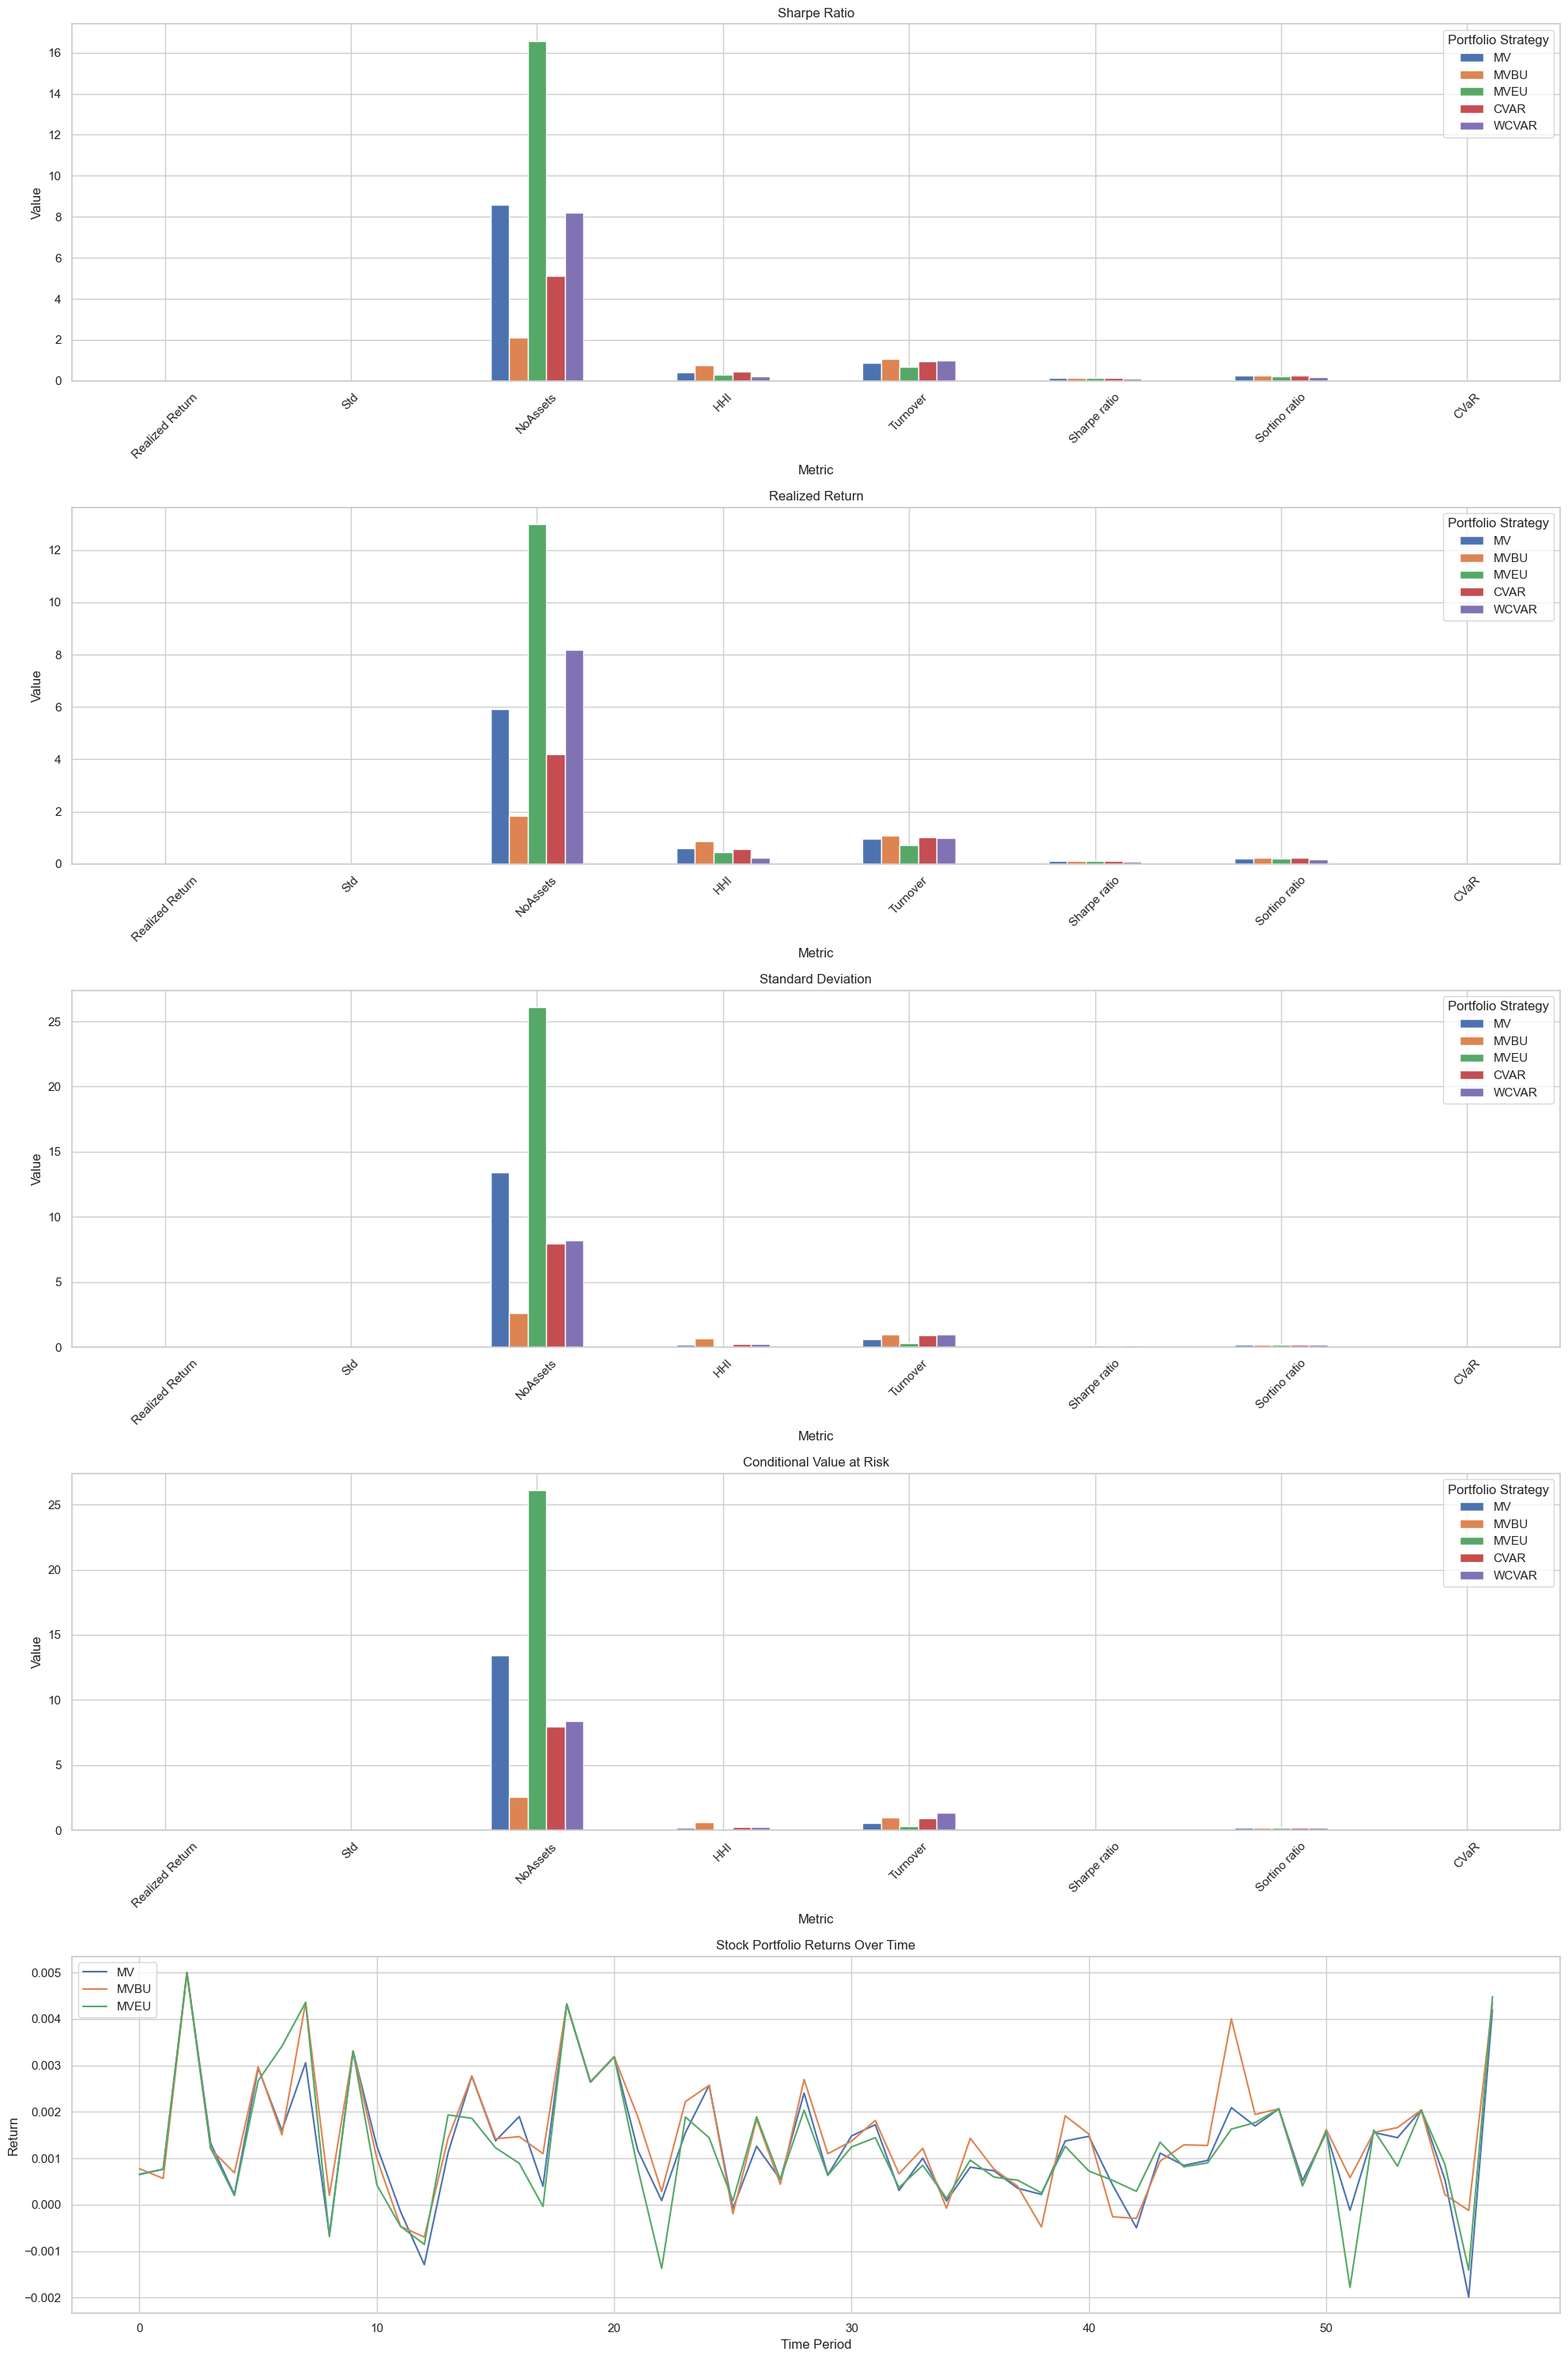

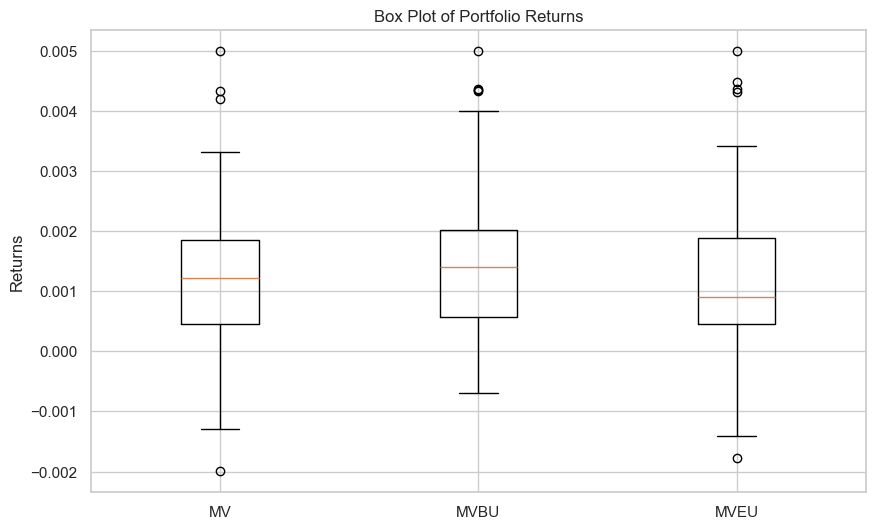

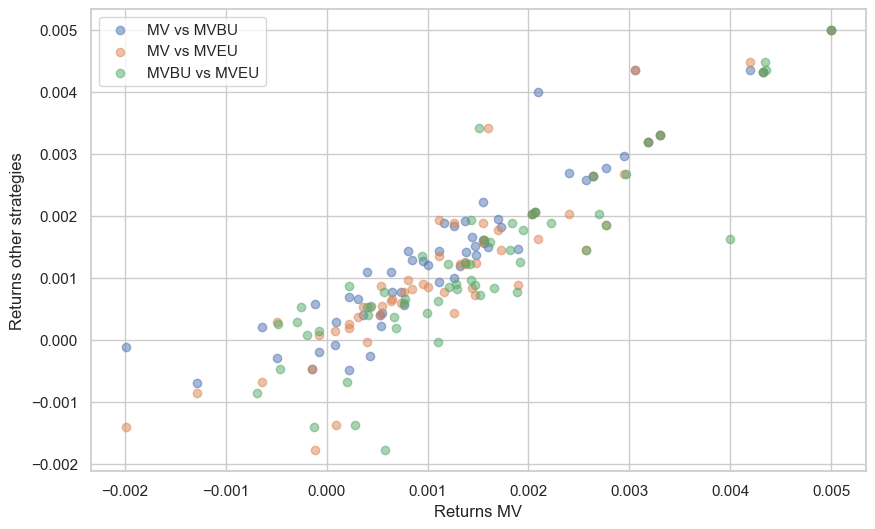

In [34]:
fig, axes = plt.subplots(5, 1, figsize=(20, 30))

# Plot 1: Sharpe Ratio
table_sc.T.plot(kind="bar", ax=axes[0], title="Sharpe Ratio")
axes[0].set_xlabel("Metric")
axes[0].set_ylabel("Value")
axes[0].legend(title="Portfolio Strategy")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Realized Return
table_ret.T.plot(kind="bar", ax=axes[1], title="Realized Return")
axes[1].set_xlabel("Metric")
axes[1].set_ylabel("Value")
axes[1].legend(title="Portfolio Strategy")
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Standard Deviation
table_std.T.plot(kind="bar", ax=axes[2], title="Standard Deviation")
axes[2].set_xlabel("Metric")
axes[2].set_ylabel("Value")
axes[2].legend(title="Portfolio Strategy")
axes[2].tick_params(axis='x', rotation=45)

# Plot 4: CVaR
table_cvar.T.plot(kind="bar", ax=axes[3], title="Conditional Value at Risk")
axes[3].set_xlabel("Metric")
axes[3].set_ylabel("Value")
axes[3].legend(title="Portfolio Strategy")
axes[3].tick_params(axis='x', rotation=45)

# Plot 5:  Returns Over Time (Line Plot)
axes[4].plot(returns_MV, label="MV")
axes[4].plot(returns_MVBU, label="MVBU")
axes[4].plot(returns_MVEU, label="MVEU")
axes[4].set_title("Stock Portfolio Returns Over Time")
axes[4].set_xlabel("Time Period")
axes[4].set_ylabel("Return")
axes[4].legend()

plt.tight_layout()
plt.show()

#Box Plot
plt.figure(figsize=(10, 6))
plt.boxplot([returns_MV, returns_MVBU, returns_MVEU], labels=['MV', 'MVBU', 'MVEU'])
plt.title('Box Plot of Portfolio Returns')
plt.ylabel('Returns')
plt.show()

#Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(returns_MV, returns_MVBU, label='MV vs MVBU', alpha =0.5)
plt.scatter(returns_MV, returns_MVEU, label='MV vs MVEU', alpha =0.5)
plt.scatter(returns_MVBU, returns_MVEU, label='MVBU vs MVEU', alpha =0.5)
plt.xlabel("Returns MV")
plt.ylabel("Returns other strategies")
plt.legend()
plt.show()